In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
### Generic imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats
from glob import glob

### ML imports
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import callbacks, regularizers
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from livelossplot.keras import PlotLossesCallback

### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Plot setup
plt.rcParams.update({
    'figure.dpi': 150,
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

Note: To type Greek letters for variables, type e.g. "\alpha" and then hit TAB.

### Load data & preprocess

Pick the selected mock stream:

In [36]:
# file = "/data0/mpettee/gaia_data/mock_streams/gaiamock_ra156.2_dec57.5_stream_feh-1.6_v3_100.npy"

Or, pick a random mock stream:

In [37]:
import random 
file = random.choice(glob("/data0/mpettee/gaia_data/mock_streams/*.npy"))
print(file)

/data0/mpettee/gaia_data/mock_streams/gaiamock_ra156.2_dec57.5_stream_feh-1.6_v3_243.npy


In [38]:
df = pd.DataFrame(np.load(file), columns=['μ_δ','μ_α','δ','α','mag','color','a','b','c','d','stream'])
df['stream'] = df['stream']/100
df['stream'] = df['stream'].astype(bool)

### Drop any rows containing a NaN value
df.dropna(inplace = True)

### Restrict data to a radius of 15
center_α = 0.5*(df.α.min()+df.α.max())
center_δ = 0.5*(df.δ.min()+df.δ.max())
df = df[np.sqrt((df.δ-center_δ)**2+(df.α-center_α)**2) < 15]

### Construct stream DataFrame
stream = df[df.stream == True]

### Optional: Reduce the background to make the problem easier.

In [41]:
# n_sig = len(df[df.stream == True])
# n_bkg = len(df[df.stream == False])
# print("Before reduction, stream stars make up {:.3f}% of the dataset.".format(100*n_sig/len(df)))

In [42]:
# fraction = 0.25
# events_to_drop = np.random.choice(df[df.stream == False].index, int(fraction*n_bkg), replace=False)
# df = df.drop(events_to_drop)
# print("After reduction, stream stars make up {:.3f}% of the dataset.".format(100*n_sig/len(df)))

### Visualize the data

First, a plot in angular spatial coordinates, highlighting GD1:

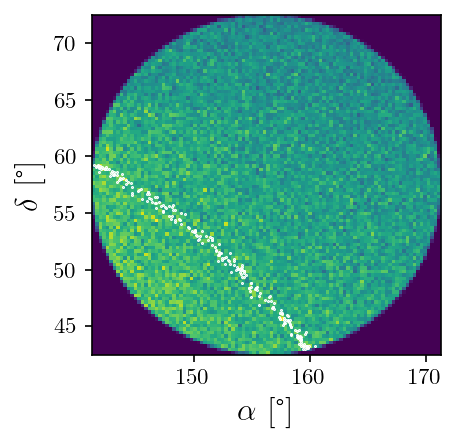

In [43]:
plt.figure(figsize=(3,3)) 
plt.hist2d(pd.concat([df.α,stream.α]),pd.concat([df.δ,stream.δ]),bins=100)
# plt.hist2d(stream.α,stream.δ, bins=100)
plt.scatter(stream.α,stream.δ,color='white',s=0.2, label="Mock Stream")
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]");
# plt.legend();

Next, the angular velocities for the background:

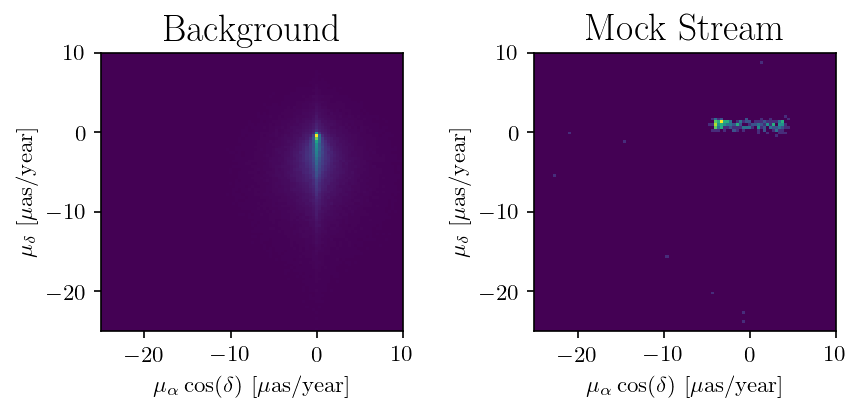

In [44]:
bins = np.linspace(-25,10,100)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3), tight_layout=True)

ax = axs[0]
ax.hist2d(df.μ_α*np.cos(df.δ),df.μ_δ, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("Background")

ax = axs[1]
ax.hist2d(stream.μ_α*np.cos(stream.δ),stream.μ_δ, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("Mock Stream");

### Define the signal & sideband regions

We want to pick a variable that is relatively localized for the mock stream. Comparing these two angular velocities, it's clear that we should pick $\mu_\delta$, as its distribution is narrower:

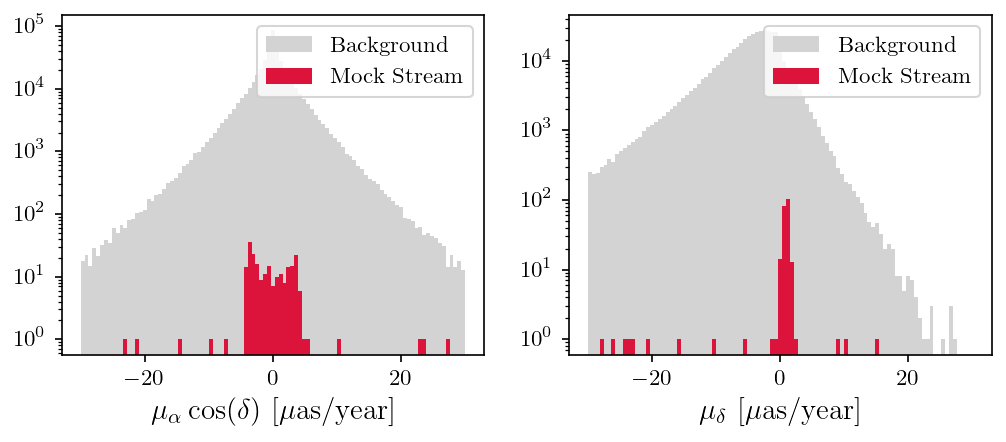

In [45]:
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
ax = axs[0]
ax.hist(df.μ_α*np.cos(df.δ), bins = np.linspace(-30,30,100), color="lightgray", label="Background")
ax.hist(stream.μ_α*np.cos(stream.δ), bins = np.linspace(-30,30,100), color="crimson", label="Mock Stream")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=14)

ax = axs[1]
ax.hist(df.μ_δ, bins = np.linspace(-30,30,100), color="lightgray", label="Background")
ax.hist(stream.μ_δ, bins = np.linspace(-30,30,100), color="crimson", label="Mock Stream")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=14);

Now we'll define the signal & sideband regions for this variable:

/tmp/ipykernel_28751/1649929064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


Signal region has 182 stream stars and 67,224 background stars.
Sideband region has 34 stream stars and 66,980 background stars.
Signal = 67,406 events | Sideband = 67,014 events.


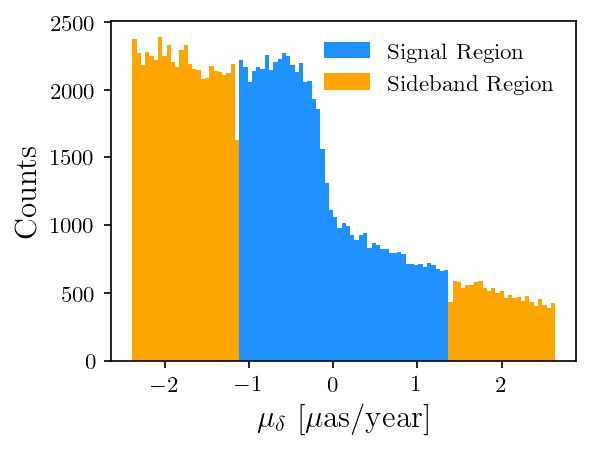

In [47]:
sb_min = df[df.stream].μ_δ.mean()-df[df.stream].μ_δ.std()/2
sb_max = df[df.stream].μ_δ.mean()+df[df.stream].μ_δ.std()/2

sr_min = df[df.stream].μ_δ.mean()-df[df.stream].μ_δ.std()/4
sr_max = df[df.stream].μ_δ.mean()+df[df.stream].μ_δ.std()/4

df_slice = df[(df.μ_δ > sb_min) & (df.μ_δ < sb_max)]
df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)

signal = df_slice[df_slice.label == 1]
sideband = df_slice[df_slice.label == 0]

print("Signal region has {:,} stream stars and {:,} background stars.".format(
    signal.stream.value_counts()[True],
    signal.stream.value_counts()[False]))
print("Sideband region has {:,} stream stars and {:,} background stars.".format(
    sideband.stream.value_counts()[True],
    sideband.stream.value_counts()[False]))

print("Signal = {:,} events | Sideband = {:,} events.".format(len(signal), len(sideband)))

plt.figure(figsize=(4,3))
bins = np.linspace(sb_min,sb_max,100)
plt.hist(df_slice[df_slice.label == 1].μ_δ,bins=bins,color="dodgerblue",label="Signal Region")
plt.hist(df_slice[df_slice.label == 0].μ_δ,bins=bins,color="orange",label="Sideband Region")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("Counts");

In [48]:
training_vars = ['μ_α','δ','α','mag','color']

# 70/15/15 train/validate/test split
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))])

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

# pre-processing by official method:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

### Train CWoLa model

In [68]:
save_name = "best_weights_mock_stream"

model = Sequential()
layer_size = 64
dropout = 0.2
# l2_reg = 1e-2
model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
               activity_regularizer=regularizers.l2(l2_reg)
               )) 
model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=regularizers.l2(l2_reg)
               ))
model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=regularizers.l2(l2_reg)
               ))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                384       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

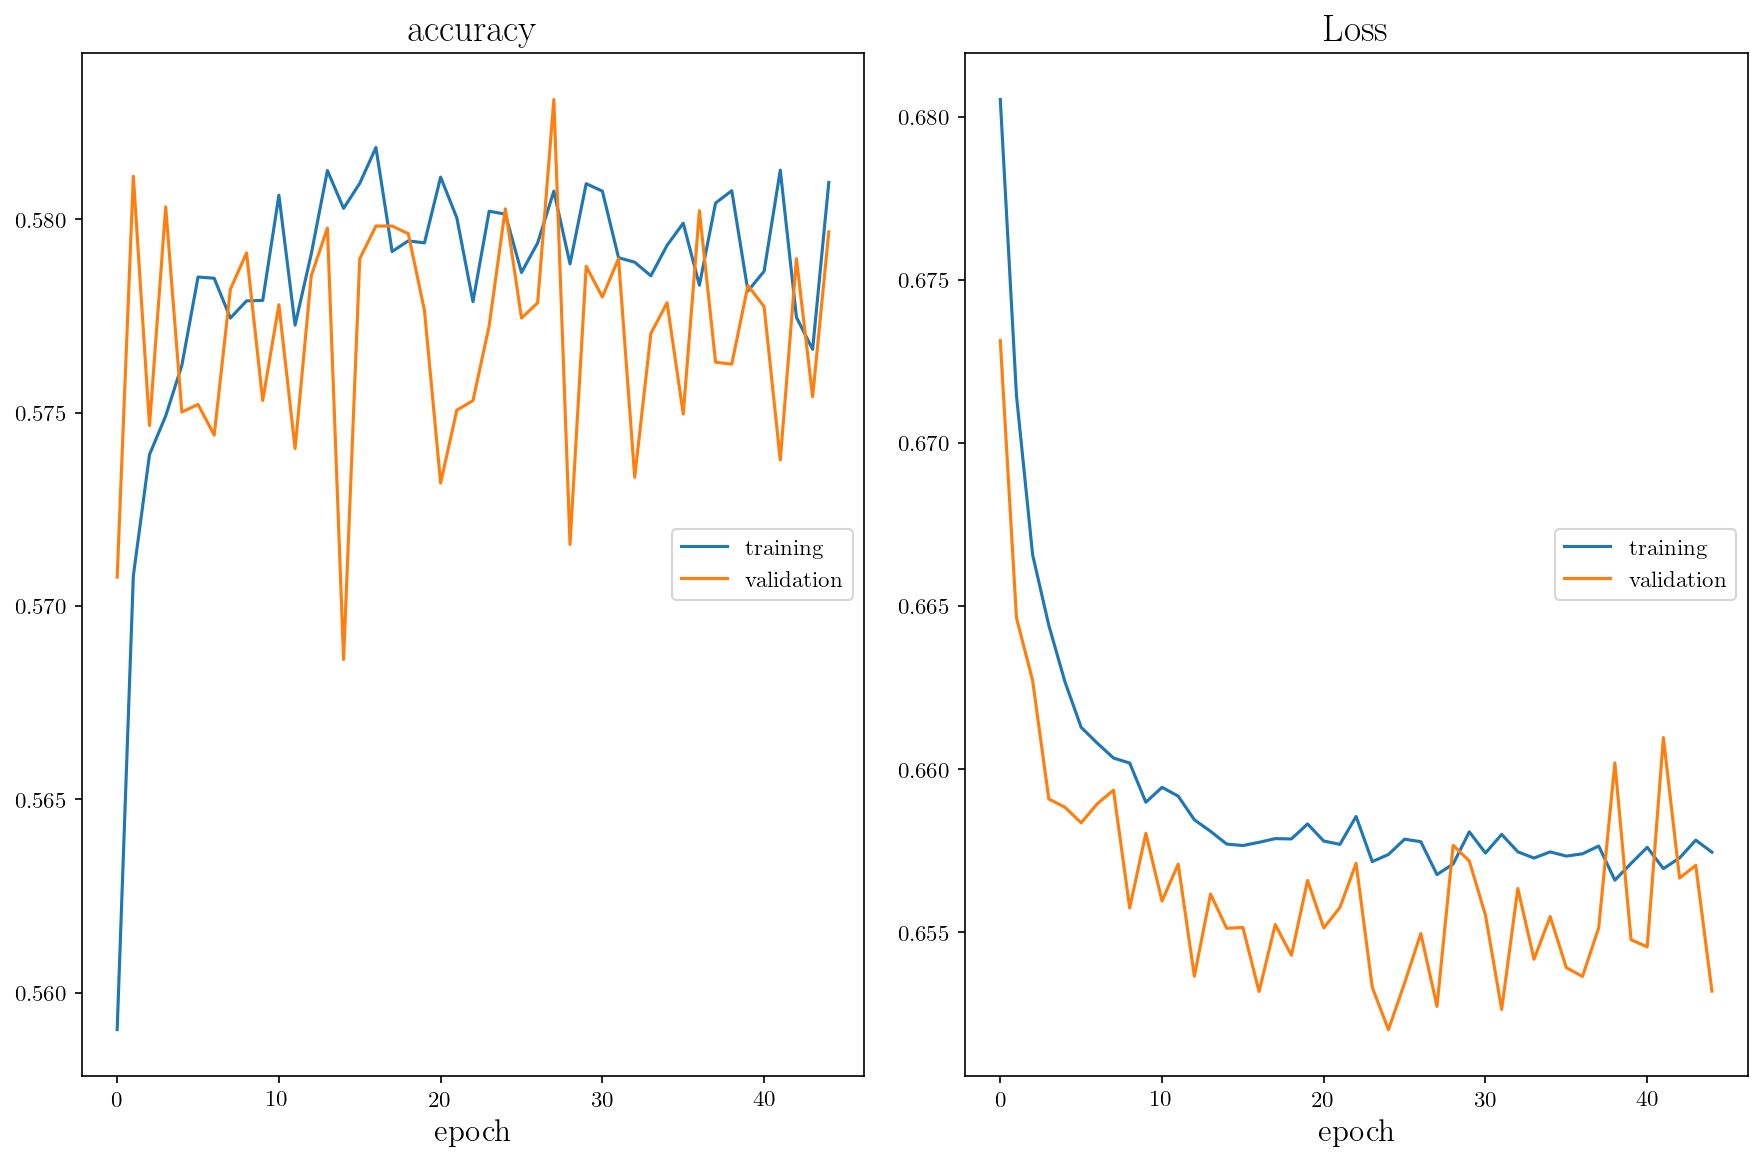

accuracy
	training         	 (min:    0.559, max:    0.582, cur:    0.581)
	validation       	 (min:    0.569, max:    0.583, cur:    0.580)
Loss
	training         	 (min:    0.657, max:    0.681, cur:    0.657)
	validation       	 (min:    0.652, max:    0.673, cur:    0.653)

Epoch 00045: val_loss did not improve from 0.65202
Epoch 00045: early stopping


In [70]:
# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=20, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
os.makedirs("./weights", exist_ok=True)
checkpoint = callbacks.ModelCheckpoint("./weights/"+save_name+".h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=32,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesCallback(),
                                checkpoint, 
                                early_stopping]
                   )

AUC: 0.6414361487219826


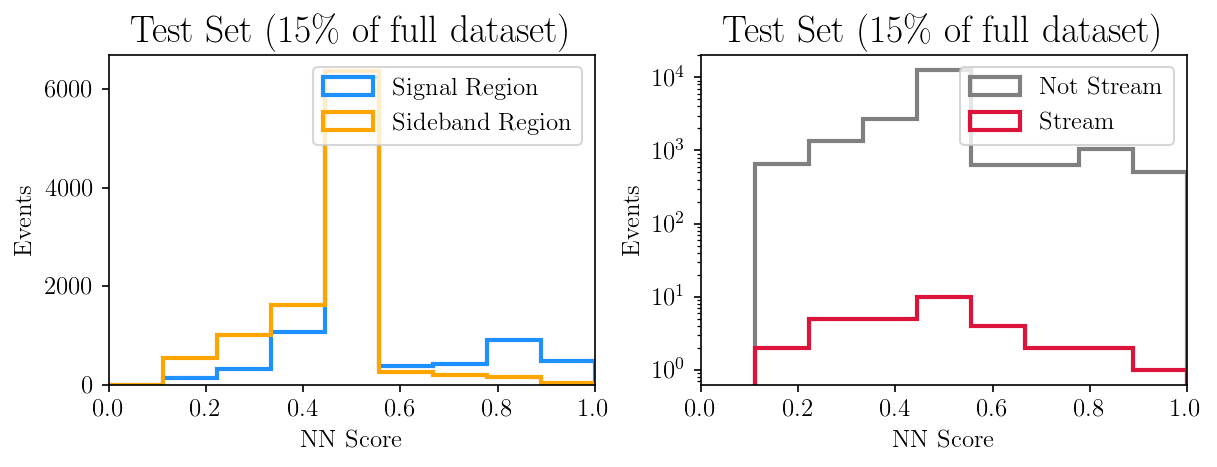

In [71]:
# Load the checkpointed model
model.load_weights("./weights/"+save_name+".h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {}".format(auc_baseline))

### Plot scores:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3), constrained_layout=True)
bins=np.linspace(0,1,10)

ax = axs[0]
ax.tick_params(labelsize=12)
ax.hist(test[test.label == 1].nn_score, bins=bins, histtype='step', linewidth=2, color="dodgerblue", label="Signal Region")
ax.hist(test[test.label == 0].nn_score, bins=bins, histtype='step', linewidth=2, color="orange", label="Sideband Region")
ax.legend(fontsize=12)
ax.set_xlim(0, 1)
ax.set_title("Test Set (15\% of full dataset)")
ax.set_xlabel("NN Score", size=12)
ax.set_ylabel("Events", size=12)

ax = axs[1]
ax.tick_params(labelsize=12)
ax.hist(test[test.stream == False].nn_score, bins=bins, histtype='step', linewidth=2, color="grey", label="Not Stream")
ax.hist(test[test.stream == True].nn_score, 
#         weights=10*np.ones(len(test[test.stream == True])), 
        bins=bins, histtype='step', linewidth=2, color="crimson", label="Stream")
ax.legend(fontsize=12)
ax.set_yscale("log")
ax.set_xlim(0, 1)
ax.set_title("Test Set (15\% of full dataset)")
ax.set_xlabel("NN Score", size=12)
ax.set_ylabel("Events", size=12);

### Make plot of highest-ranked stars

Maximum purity of 0.4% at 12.66%


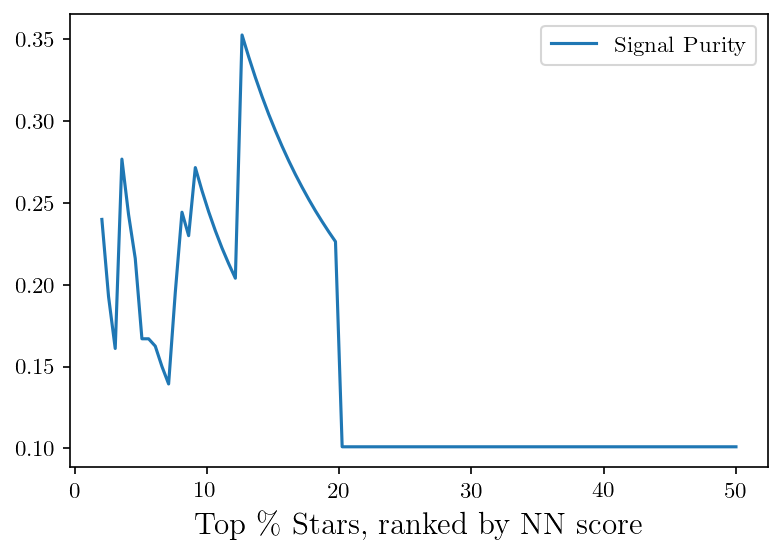

In [72]:
# Scan for optimal percentage
cuts = np.linspace(0.05, 50, 100)
efficiencies = []
purities = []
for x in cuts:
    top_stars = test[(test['nn_score'] >= test['nn_score'].quantile((100-x)/100))]
    if True in top_stars.stream.unique():
        n_perfect_matches = top_stars.stream.value_counts()[True]
        stream_stars_in_test_set = test[test.stream == True]
        efficiencies.append(100*n_perfect_matches/len(stream_stars_in_test_set))
        purities.append(n_perfect_matches/len(top_stars)*100)
    else:
        efficiencies.append(np.nan)
        purities.append(np.nan)

sum = np.array(efficiencies)+np.array(purities)

### Choose a cut to optimize purity
print("Maximum purity of {:.1f}% at {:.2f}%".format(np.nanmax(purities),cuts[np.nanargmax(purities)]))
cut = cuts[np.nanargmax(purities)]

# plt.plot(cuts, efficiencies, label="Signal Efficiency")
plt.plot(cuts, purities, label="Signal Purity")
# plt.plot(cuts, sum, label="Sum")
plt.xlabel("Top \% Stars, ranked by NN score")
plt.legend()

Plot top $x\%$ of stars by NN score:

In [79]:
# # ### Use optimal cut point 
# x = cut # desired percentage
# print("Using optimal cut of {:.1f}% for purity.".format(cut))
# top_stars = test[(test['nn_score'] >= test['nn_score'].quantile((100-x)/100))]

# ### Or choose your own percentage:
x = 10
top_stars = test[(test['nn_score'] >= test['nn_score'].quantile((100-x)/100))]

# ### Or pick nn_scores above 90%: 
# # top_stars = test[(test['nn_score'] >= 0.99)]

Or, just plot the top $N$ stars:

In [80]:
# N = 100
# top_stars = test.sort_values(by=["nn_score"],ascending=False)[:N]

How much do these stars overlap with the true stream stars?

- **Efficiency** = what percent of stream stars were identified by the NN?
- **Purity** = what percentage of the top stars identified are actually stream stars? 

In [81]:
n_perfect_matches = top_stars.stream.value_counts()[True]
stream_stars_in_test_set = test[test.stream == True]

print("Efficiency: {:.1f}%".format(100*n_perfect_matches/len(stream_stars_in_test_set)))
print("Purity: {:.1f}%".format(n_perfect_matches/len(top_stars)*100))

Efficiency: 16.1%
Purity: 0.2%


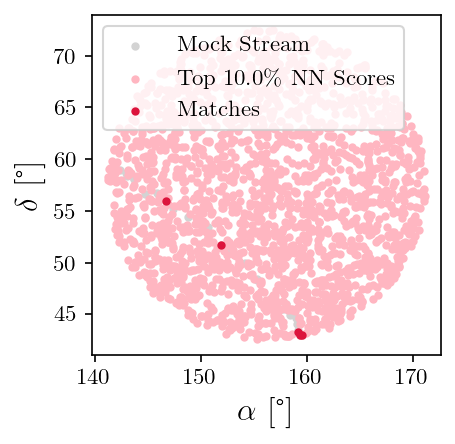

In [82]:
plt.figure(figsize=(3,3)) 
plt.scatter(stream_stars_in_test_set.α, stream_stars_in_test_set.δ, marker='.', 
            # s = 1.0, 
#             alpha = 0.5,
            color = "lightgray",
            label='Mock Stream')
plt.scatter(top_stars.α, top_stars.δ, marker='.', 
            # s = 1.0,
#             alpha = 0.5,
            color = "lightpink",
#             label = 'Top {} stars'.format(N))
            label='Top {:.1f}\% NN Scores'.format(x))
plt.scatter(top_stars[top_stars.stream].α, top_stars[top_stars.stream].δ, marker='.', 
            # s = 1.0,
#             alpha = 0.5,
            color = "crimson",
            label='Matches')
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]");